<a href="https://colab.research.google.com/github/KevinCantrell/pHstrips/blob/main/Absorbance_to_Color_Coordinates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

required Excel file with CIE color information
https://www.rit.edu/science/munsell-color-science-lab-educational-resources?ref=rit-search#useful-color-data

Full set of 1nm data, including all of the following:
*    Illuminant D65
*    VM(λ) 1988 Spectral Luminous Efficiency Function for photopic vision
*    V'(λ) Spectral Luminous Efficiency Function for scotopic vision
*    1931 2° CIE Standard Colorimetric Observer Data
*    1964 10 °CIE Standard Colorimetric Observer Data
*    Excel with all of the above
save as 'all_1nm_data.xls'

In [14]:
import math
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [2]:
def ShiftHOriginToValue(hue, maxHue, newOrigin, direction="cw"):
    shifthsv = np.copy(hue).astype("float")
    shiftAmount = maxHue - newOrigin
    shifthsv[hue < newOrigin] = shifthsv[hue < newOrigin] + shiftAmount
    shifthsv[hue >= newOrigin] = shifthsv[hue >= newOrigin] - newOrigin
    hue = shifthsv
    if direction == "ccw":
        hue = maxHue - hue
    return hue

def absorbanceToTristim(waves, absorbance, Yr, gammaFlag=True):
    pixel = np.zeros((1, 1, 3), dtype=np.float32)
    pixel[0, 0, 0] = np.trapezoid(CIEX * illum * 10 ** -absorbance, waves) / Yr
    pixel[0, 0, 1] = np.trapezoid(CIEY * illum * 10 ** -absorbance, waves) / Yr
    pixel[0, 0, 2] = np.trapezoid(CIEZ * illum * 10 ** -absorbance, waves) / Yr
    XYZ = pixel[0, 0, :]
    RGB = cv2.cvtColor(pixel, cv2.COLOR_XYZ2RGB)
    RGBg = np.zeros((RGB.shape), dtype=np.float32)
    for cc in range(RGB.shape[2]):
        if RGB[0, 0, cc] <= 0.0031308:
            RGBg[0, 0, cc] = 12.92 * RGB[0, 0, cc]
        else:
            RGBg[0, 0, cc] = 1.055 * RGB[0, 0, cc] ** (1 / 2.4) - 0.055
        if RGBg[0, 0, cc] > 1:
            RGBg[0, 0, cc] = 1
        elif RGBg[0, 0, cc] < 0:
            RGBg[0, 0, cc] = 0
    if gammaFlag:
        HSV = cv2.cvtColor(RGBg, cv2.COLOR_RGB2HSV)[0, 0, :]
        LAB = cv2.cvtColor(RGBg, cv2.COLOR_RGB2LAB)[0, 0, :]
        RGB = RGB[0, 0, :]
        RGBg = RGBg[0, 0, :]
        rgb = np.zeros((RGBg.shape))
        rgb[0] = RGBg[0] / np.sum(RGBg)
        rgb[1] = RGBg[1] / np.sum(RGBg)
        rgb[2] = RGBg[2] / np.sum(RGBg)
        rat = np.zeros((RGBg.shape))
        rat[0] = RGBg[0] / RGBg[1]
        rat[1] = RGBg[0] / RGBg[2]
        rat[2] = RGBg[1] / RGBg[2]
    else:
        HSV = cv2.cvtColor(RGB, cv2.COLOR_RGB2HSV)[0, 0, :]
        LAB = cv2.cvtColor(RGB, cv2.COLOR_RGB2LAB)[0, 0, :]
        RGB = RGB[0, 0, :]
        RGBg = RGBg[0, 0, :]
        rgb = np.zeros((RGB.shape))
        rgb[0] = RGB[0] / np.sum(RGB)
        rgb[1] = RGB[1] / np.sum(RGB)
        rgb[2] = RGB[2] / np.sum(RGB)
        rat = np.zeros((RGB.shape))
        rat[0] = RGB[0] / RGB[1]
        rat[1] = RGB[0] / RGB[2]
        rat[2] = RGB[1] / RGB[2]
    HSV[0] = ShiftHOriginToValue(HSV[0], 360, 360.0 / 3, direction="ccw")
    HSV[0] = HSV[0] / 360.0
    LAB[0] = LAB[0] / 100.0
    LAB[1] = (LAB[1] + 128) / 255.0
    LAB[2] = (LAB[2] + 128) / 255.0
    RGBg = np.rint(RGBg * 255) / 255.0
    return RGB, HSV, LAB, XYZ, rgb, rat, RGBg

In [7]:
waves = np.arange(360, 820, 0.1)

#colorDataFrame = pd.read_excel("all_1nm_data.xls", skiprows=63)
colorDataFrame = pd.read_excel("https://raw.githubusercontent.com/KevinCantrell/pHstrips/bbb55146a42882688b320c0d3eeb88fcf2f26797/all_1nm_data.xls", skiprows=63)

fCIEX = interp1d(colorDataFrame.values[:, 0], colorDataFrame.values[:, 5], kind="cubic")
fCIEY = interp1d(colorDataFrame.values[:, 0], colorDataFrame.values[:, 6], kind="cubic")
fCIEZ = interp1d(colorDataFrame.values[:, 0], colorDataFrame.values[:, 7], kind="cubic")
fD65 = interp1d(colorDataFrame.values[:, 0], colorDataFrame.values[:, 2], kind="cubic")
CIEX = fCIEX(waves)
CIEY = fCIEY(waves)
CIEZ = fCIEZ(waves)
D65 = fD65(waves)
illum = D65
Yr = np.trapezoid(CIEY * illum, waves)

[Text(400, 0, '400'),
 Text(500, 0, '500'),
 Text(600, 0, '600'),
 Text(700, 0, '700'),
 Text(800, 0, '800')]

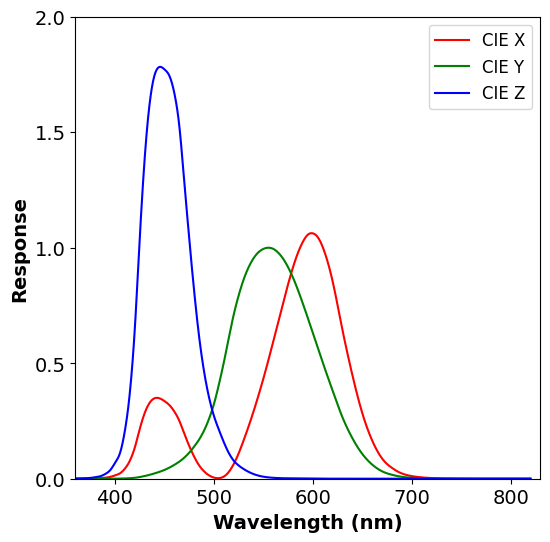

In [8]:
rcParams["font.family"] = 'DejaVu Sans'
#rcParams["font.sans-serif"] = ["Arial"]

fontSizeLarge = 14
fontSizeLargest = 18
fontSizeSmall = 12
fontSizeLegend = 12

figColor, cie = plt.subplots(1, 1, figsize=(6, 6))
cie.plot(waves, CIEX, "r", label="CIE X")
cie.plot(waves, CIEY, "g", label="CIE Y")
cie.plot(waves, CIEZ, "b", label="CIE Z")
cie.set_xlabel("Wavelength (nm)", fontsize=fontSizeLarge, fontweight="bold")
cie.set_ylabel("Response", fontsize=fontSizeLarge, fontweight="bold")
legend = cie.legend(loc="upper right", fontsize=fontSizeLegend)
cie.set_xlim([360, 830])
cie.set_ylim([0, 2])
cie.set_yticks(np.array([0, 0.5, 1, 1.5, 2]))
cie.set_yticklabels(np.array([0, 0.5, 1, 1.5, 2]), fontsize=fontSizeLarge)
cie.set_xticks(np.array([400, 500, 600, 700, 800]))
cie.set_xticklabels(np.array([400, 500, 600, 700, 800]), fontsize=fontSizeLarge)

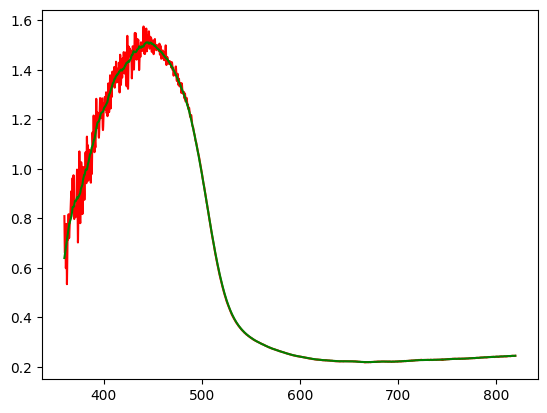

In [24]:
absorbanceData = pd.read_table("/content/Paper Abs What 3-1 pH 040.txt",header=None,names=["wave","abs"])

funcAbs = interp1d(absorbanceData['wave'].values,absorbanceData['abs'].values, kind="cubic")
absorbance=funcAbs(waves)
plt.plot(waves,absorbance,"r-")
absorbance=savgol_filter(absorbance,101,1)
plt.plot(waves,absorbance,"g-")


[218. 170.   0.]
[183.40576 133.32812 202.9375 ]


/tmp/ipython-input-1761286132.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  rat[1] = RGBg[0] / RGBg[2]
/tmp/ipython-input-1761286132.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  rat[2] = RGBg[1] / RGBg[2]


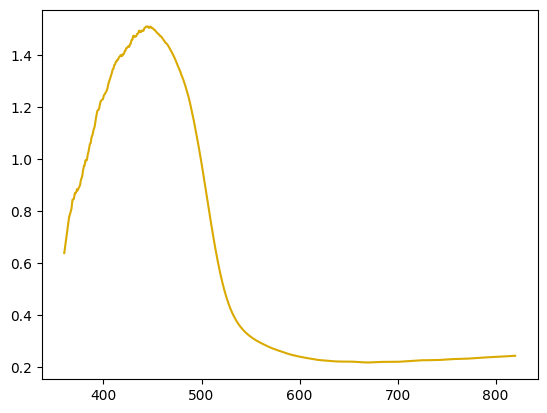

In [26]:
RGB, HSV, LAB, XYZ, rgb, rat, RGBg =absorbanceToTristim(waves, absorbance, Yr, gammaFlag=True)
print(RGBg*255)
for cc,index in zip(RGB,range(len(RGB))):
  if cc>1:
    RGB[index]=1
  if cc<0:
    RGB[index]=0
print(LAB*255)

plt.plot(waves,absorbance,color=RGBg)

In [27]:
print(HSV[0]*360)

73.16098
